In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 

In [2]:
print(os.listdir('../input'))

['spoken-language-identification']


In [3]:
import numpy as np # linear algebra
np.random.seed(1337) #reproducibility
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import os
import pandas as pd
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
import gc
import IPython.display as ipd 

In [5]:
train_path = '../input/spoken-language-identification/train/train/'
test_path = '../input/spoken-language-identification/test/test/'

In [6]:
filename = 'de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.flac'#Free Lossless Audio Codec format. FLAC is a popular audio format known for its lossless compression, meaning it preserves the original audio quality while reducing file size.

In [7]:
data, samplerate = sf.read(train_path+filename)

In [8]:
import os
print(os.listdir('../input'))
import pandas as pd

['spoken-language-identification']


In [9]:
import gc
gc.collect()

0

In [10]:
data.shape

(220500,)

In [11]:
data[:10]

array([-0.03903198, -0.03997803, -0.05319214, -0.06002808, -0.0531311 ,
       -0.04608154, -0.04348755, -0.02947998, -0.02307129, -0.02459717])

In [12]:
samplerate

22050

In [13]:
ipd.Audio(train_path+filename)

Text(0.5, 0, 'Time [sec]')

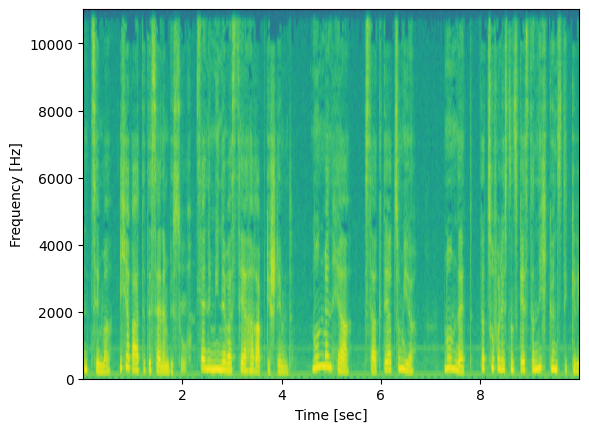

In [14]:
Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)

# add axis labels
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time in samples')

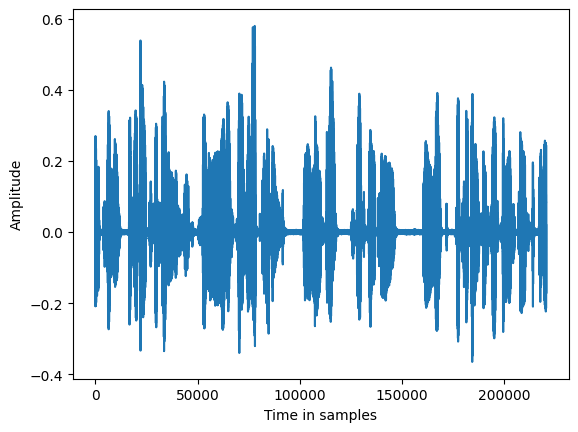

In [15]:
plt.plot(data)

# add axis labels
plt.ylabel('Amplitude')
plt.xlabel('Time in samples')

In [16]:
filename[:2]

'de'

In [17]:
label = []
for filename in os.listdir(train_path):
    label.append(filename[:2])  

In [18]:
label_t = []
for filename in os.listdir(test_path):
    label_t.append(filename[:2])

In [19]:
print(len(label))
print(len(label_t))

73080
540


In [20]:
file = []
for filename in os.listdir(train_path):
    file.append(filename)

In [21]:
file_t = []
for filename in os.listdir(test_path):
    file_t.append(filename)

In [22]:
Label = pd.DataFrame(label,columns=['Language'])

In [23]:
Label['Language'].value_counts()

Language
es    24360
de    24360
en    24360
Name: count, dtype: int64

In [24]:
data = {'filename':file,
       'languange':label}


In [25]:
data_t = {'filename':file_t,
       'languange':label_t}

In [26]:
df = pd.DataFrame(data)

In [27]:
df_t = pd.DataFrame(data_t)

In [28]:
df['filename'][0]

'es_m_b53274d3ef7996a22d6ec929c1869804.fragment12.speed1.flac'

In [29]:
def generate_fb_and_mfcc(signal, sample_rate):

    # Pre-Emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[:-1])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01

    # Convert from seconds to samples
    frame_length, frame_step = (
        frame_size * sample_rate,
        frame_stride * sample_rate)
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Make sure that we have at least 1 frame
    num_frames = int(
        np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)

    indices = (
        np.tile(np.arange(0, frame_length), (num_frames, 1)) +
        np.tile(
            np.arange(0, num_frames * frame_step, frame_step),
            (frame_length, 1)
        ).T
    )
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Window
    frames *= np.hamming(frame_length)

    # Fourier-Transform and Power Spectrum
    NFFT = 512

    # Magnitude of the FFT
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

    # Power Spectrum
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Filter Banks
    nfilt = 40

    low_freq_mel = 0

    # Convert Hz to Mel
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))

    # Equally spaced in Mel scale
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

    # Convert Mel to Hz
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)

    filter_banks = np.where(
        filter_banks == 0,
        np.finfo(float).eps,
        filter_banks)

    filter_banks = 20 * np.log10(filter_banks)
    return filter_banks

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train,X_test,y_train,y_test = train_test_split(df,df['languange'],stratify = df['languange'],test_size = 0.5,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

languange
en    12180
de    12180
es    12180
Name: count, dtype: int64
languange
es    12180
en    12180
de    12180
Name: count, dtype: int64


In [32]:
X_train,X_test,y_train,y_test = train_test_split(X_train,X_train['languange'],stratify = X_train['languange'],test_size = 0.5,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

languange
en    6090
de    6090
es    6090
Name: count, dtype: int64
languange
en    6090
de    6090
es    6090
Name: count, dtype: int64


In [33]:
X_train,X_test,y_train,y_test = train_test_split(X_train,X_train['languange'],stratify = X_train['languange'],test_size = 0.5,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

languange
de    3045
en    3045
es    3045
Name: count, dtype: int64
languange
es    3045
en    3045
de    3045
Name: count, dtype: int64


In [34]:
X_train,X_test,y_train,y_test = train_test_split(X_train,X_train['languange'],stratify = X_train['languange'],test_size = 0.6,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

languange
en    1218
es    1218
de    1218
Name: count, dtype: int64
languange
en    1827
de    1827
es    1827
Name: count, dtype: int64


In [35]:
X_train['filename'].values[:2]

array(['en_f_fff98d05640df27726dcd6183642ffaa.fragment24.speed5.flac',
       'en_m_f7d28f7498eaf373b312abcdc0886951.fragment15.speed6.flac'],
      dtype=object)

In [36]:
X_train.head()

,filename,languange
49335,en_f_fff98d05640df27726dcd6183642ffaa.fragment...,en
71901,en_m_f7d28f7498eaf373b312abcdc0886951.fragment...,en
47355,en_f_386ee651f6f1539ff5622c55e234e5a4.fragment...,en
12633,en_m_011f3a2d0aa2880305c08b76873c3e10.fragment...,en
58639,es_f_47bd2e6178465cd745c86c9db5ffe447.fragment...,es


In [37]:
X_train = X_train.reset_index(drop = True)
X_train.head()

,filename,languange
0,en_f_fff98d05640df27726dcd6183642ffaa.fragment...,en
1,en_m_f7d28f7498eaf373b312abcdc0886951.fragment...,en
2,en_f_386ee651f6f1539ff5622c55e234e5a4.fragment...,en
3,en_m_011f3a2d0aa2880305c08b76873c3e10.fragment...,en
4,es_f_47bd2e6178465cd745c86c9db5ffe447.fragment...,es


In [38]:
gc.collect()

0

In [39]:
series = []
length = []
for filename in X_train['filename'].values:
    flac, samplerate = sf.read(train_path+filename)
    series.append(flac)
    length.append(samplerate)


In [40]:
X_train['Series'] = series
X_train['Length'] = length
X_train.head(20)

,filename,languange,Series,Length
0,en_f_fff98d05640df27726dcd6183642ffaa.fragment...,en,"[0.0028076171875, 0.003875732421875, 0.0036315...",22050
1,en_m_f7d28f7498eaf373b312abcdc0886951.fragment...,en,"[0.010040283203125, 0.013763427734375, 0.00262...",22050
2,en_f_386ee651f6f1539ff5622c55e234e5a4.fragment...,en,"[-0.00933837890625, -0.00225830078125, 0.02273...",22050
3,en_m_011f3a2d0aa2880305c08b76873c3e10.fragment...,en,"[0.07745361328125, 0.10418701171875, 0.0921325...",22050
4,es_f_47bd2e6178465cd745c86c9db5ffe447.fragment...,es,"[0.043182373046875, 0.029876708984375, 0.01992...",22050
5,en_f_c8835fb3edef243176e1e9beef1f9681.fragment...,en,"[0.014404296875, 0.010498046875, -0.0144653320...",22050
6,es_m_d5b91a4ffb1ead826b7968ec19cbfa1c.fragment...,es,"[6.103515625e-05, 0.000244140625, 0.0001525878...",22050
7,es_m_d5b91a4ffb1ead826b7968ec19cbfa1c.fragment...,es,"[0.0157470703125, 0.01593017578125, 0.01367187...",22050
8,es_m_406bb0dc71a22051d900bc55cdfad59e.fragment...,es,"[0.002777099609375, 0.00482177734375, 0.006683...",22050
9,en_f_10134f409d9b7b0b95fed6e025febcad.fragment...,en,"[-0.00299072265625, -0.004241943359375, -0.002...",22050


In [41]:
len(X_train)

3654

In [42]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [43]:
gc.collect()

0

In [44]:
MFCC_array = []
for i in range(0,len(X_train)):
    MFCC = generate_fb_and_mfcc(X_train['Series'][i], X_train['Length'][i])
    MFCC_sc = sc.fit_transform(MFCC)
    MFCC_array.append(MFCC_sc)
MFCC_array = np.array(MFCC_array)

In [45]:
np.save('../working/MFCC_data',MFCC_array)

In [46]:
series_t = []
length_t = []
for filename in df_t['filename'].values:
    flac, samplerate = sf.read(test_path+filename)
    series_t.append(flac)
    length_t.append(samplerate)

In [47]:
df_t['Series'] = series_t
df_t['Length'] = length_t
df_t.head()

,filename,languange,Series,Length
0,es_f_50298ab71aaba8508ebeef49d853df11.fragment...,es,"[0.079864501953125, 0.079193115234375, 0.08142...",22050
1,es_m_08111ce8d6a7ebc6cd2c27e62a3d98f0.fragment...,es,"[3.0517578125e-05, 6.103515625e-05, 3.05175781...",22050
2,en_f_67a0cba10d171b24039a79faa1d4d603.fragment...,en,"[0.000274658203125, 0.0003662109375, 0.0004272...",22050
3,de_m_923551d571cc437382d0294dda2dd0aa.fragment...,de,"[-0.1868896484375, -0.177001953125, -0.1701660...",22050
4,es_f_50298ab71aaba8508ebeef49d853df11.fragment...,es,"[0.127655029296875, 0.127105712890625, 0.12649...",22050


In [48]:
MFCC_array_t = []
for i in range(0,len(df_t)):
    MFCC = generate_fb_and_mfcc(df_t['Series'][i], df_t['Length'][i])
    MFCC_sc = sc.fit_transform(MFCC)
    MFCC_array_t.append(MFCC_sc)
MFCC_array_t = np.array(MFCC_array_t) 

In [49]:
np.save('../working/MFCC_data_t',MFCC_array_t)

In [50]:
#language dummies tiene los one hot encoding para X_train
#language dummies_t tiene los one hot encoding para df_t; i.e. [0, 1, 0], etc
language_dummies = pd.get_dummies(X_train['languange'])
language_dummies_t = pd.get_dummies(df_t['languange'])
np.save('../working/language_dummy',language_dummies.values)
np.save('../working/language_dummy_t',language_dummies_t.values)

In [51]:
import librosa
import librosa.display

In [52]:
MFCC_array = np.load('../working/MFCC_data.npy')

In [53]:
language_dummies = np.load('../working/language_dummy.npy')
language_dummies_t = np.load('../working/language_dummy_t.npy')

In [54]:
language_dummies_t[:5]

array([[False, False,  True],
       [False, False,  True],
       [False,  True, False],
       [ True, False, False],
       [False, False,  True]])

In [55]:
X_train_MFCC,X_test_MFCC,y_train_MFCC,y_test_MFCC = train_test_split(MFCC_array,language_dummies,stratify = language_dummies,test_size = 0.10,random_state = 0)

In [56]:
X_train_MFCC.shape

(3288, 1000, 40)

In [57]:
X_train_MFCC = X_train_MFCC.reshape(-1,1000,40,1)

In [58]:
X_test_MFCC = X_test_MFCC.reshape(-1,1000,40,1)

In [59]:
y_train_MFCC 
y_test_MFCC
len(X_train_MFCC)

3288

In [60]:
!pip install keras

In [61]:
# Importing necessary modules from Keras
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model

# Check if the Keras version is compatible with BatchNormalization
import keras
if int(keras.__version__.split('.')[0]) >= 2:  # Check if using Keras 2.x
    from keras.layers import BatchNormalization
else:  # If using Keras 1.x
    from keras.layers.normalization import BatchNormalization

from keras import regularizers

2024-02-15 03:44:49.847111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 03:44:49.847236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 03:44:49.998546: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [62]:
# Importing necessary modules from Keras
from keras.optimizers import Nadam, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical  # Import to_categorical instead of np_utils
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model

In [63]:
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix

from keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten
from keras.layers import Dropout, Input, Activation
from keras.optimizers import Nadam, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model
from keras.layers import BatchNormalization
from keras import regularizers

In [64]:
import math

In [65]:
input_shape = (1000,40,1)
model = Sequential()

model.add(Conv2D(32,(7, 7), activation='relu', padding='valid', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(64,(5,5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(512,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


from keras.callbacks import LearningRateScheduler
adam = Adam()
def step_decay(epoch):
    # 00158 = 90.4%
	initial_lrate = 0.00158
	drop = 0.9
	epochs_drop = 1
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



checkpoint = ModelCheckpoint(
                'model.h5',
                monitor='val_acc',
                verbose=0,
                save_best_only=True,
                mode='max'
                )

lrate = LearningRateScheduler(step_decay)
#es = EarlyStopping(monitor='val_loss',mode = 'max')
hist=model.fit(
                X_train_MFCC,
                y_train_MFCC,
                epochs=60,
                callbacks=[checkpoint, lrate],
                verbose=1,
                validation_data=(X_test_MFCC, y_test_MFCC),
                batch_size=32)

Epoch 1/60
103/103 [==============================] - 259s 2s/step - loss: 1.3973 - accuracy: 0.4787 - val_loss: 2.4852 - val_accuracy: 0.3443 - lr: 0.0014
Epoch 2/60
103/103 [==============================] - 245s 2s/step - loss: 0.6801 - accuracy: 0.7530 - val_loss: 0.8663 - val_accuracy: 0.6202 - lr: 0.0013
Epoch 3/60
103/103 [==============================] - 254s 2s/step - loss: 0.3690 - accuracy: 0.8653 - val_loss: 1.7127 - val_accuracy: 0.5492 - lr: 0.0012
Epoch 4/60
103/103 [==============================] - 247s 2s/step - loss: 0.2342 - accuracy: 0.9188 - val_loss: 0.5251 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 5/60
103/103 [==============================] - 247s 2s/step - loss: 0.1376 - accuracy: 0.9529 - val_loss: 1.0649 - val_accuracy: 0.6995 - lr: 9.3297e-04
Epoch 6/60
103/103 [==============================] - 246s 2s/step - loss: 0.1155 - accuracy: 0.9583 - val_loss: 0.6398 - val_accuracy: 0.8197 - lr: 8.3968e-04
Epoch 7/60
103/103 [==============================] - 24

In [67]:
model.evaluate(X_test_MFCC,y_test_MFCC)

12/12 [==============================] - 7s 565ms/step - loss: 0.0475 - accuracy: 0.9781


[0.0474911630153656, 0.9781420826911926]

In [68]:
y_pred = model.predict(X_test_MFCC)

12/12 [==============================] - 7s 579ms/step


In [69]:
y_test1 = []
for i in range(0,len(y_test_MFCC)):
    argmax = np.argmax(y_test_MFCC[i,:])
    y_test1.append(argmax)

In [70]:
y_pred1 = []
for i in range(0,len(y_test_MFCC)):
    argmax = np.argmax(y_pred[i,:])
    y_pred1.append(argmax)

In [71]:
confusion_matrix(y_test1,y_pred1)

array([[120,   2,   0],
       [  4, 117,   1],
       [  0,   1, 121]])

In [72]:
print(classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       122
           1       0.97      0.96      0.97       122
           2       0.99      0.99      0.99       122

    accuracy                           0.98       366
   macro avg       0.98      0.98      0.98       366
weighted avg       0.98      0.98      0.98       366



In [73]:
MFCC_array_t = np.load('../working/MFCC_data_t.npy')

In [74]:
MFCC_array_t.shape

(540, 1000, 40)

In [75]:
MFCC_array_t = MFCC_array_t.reshape(-1,1000,40,1)

In [76]:
predictions = model.predict(MFCC_array_t)

17/17 [==============================] - 19s 1s/step


In [77]:
predictions

array([[1.8998063e-06, 8.0853835e-10, 9.9999803e-01],
       [2.1001790e-05, 2.1486294e-06, 9.9997681e-01],
       [2.9094890e-04, 9.9970877e-01, 1.8138752e-07],
       ...,
       [5.1042858e-05, 9.7794044e-01, 2.2008449e-02],
       [1.1004447e-07, 9.9999952e-01, 3.7062347e-07],
       [3.0780189e-05, 4.2157058e-06, 9.9996495e-01]], dtype=float32)

In [78]:
y_pred1 = []
for i in range(0,len(predictions)):
    argmax = np.argmax(predictions[i,:])
    y_pred1.append(argmax)

In [79]:
y_test1 = []
for i in range(0,len(language_dummies_t)):
    argmax = np.argmax(language_dummies_t[i,:])
    y_test1.append(argmax)

In [80]:
#confusion_matrix(y_test1,y_pred1)
cm = confusion_matrix(y_test1,y_pred1)
print(np.around(cm/cm.sum(axis=1, keepdims=True)*100,1))

[[ 98.3   1.1   0.6]
 [  0.   96.7   3.3]
 [  0.    0.  100. ]]


In [81]:
print(classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       180
           1       0.99      0.97      0.98       180
           2       0.96      1.00      0.98       180

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


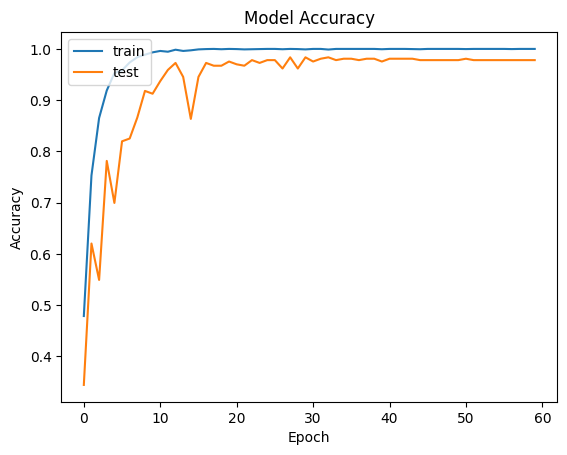

In [83]:
print(hist.history.keys())

plt.plot(hist.history['accuracy'])  # Use 'accuracy' instead of 'acc'
plt.plot(hist.history['val_accuracy'])  # Use 'val_accuracy' instead of 'val_acc'
plt.title('Model Accuracy')  # Update the title accordingly

# Add labels for the axes
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()
